# Challenge: Validating a linear regression
### Validating regression models for prediction
Statistical tests are useful for making sure a model is a good fit to the test data, and that all the features are useful to the model. However, to make sure a model has good predictive validity for new data, it is necessary to assess the performance of the model on new datasets.

The procedure is the same as what you learned in the Naive Bayes lesson – the holdout method and cross-validation method are both available. You've already had experience writing code to run these kinds of validation models for Naive Bayes: now you can try it again with linear regression. In this case, your goal is to achieve a model with a consistent R2 and only statistically significant parameters across multiple samples.

We'll use the property crime model you've been working on with, based on the FBI:UCR data. Since your model formulation to date has used the entire New York State 2013 dataset, you'll need to validate it using some of the other crime datasets available at the FBI:UCR website. Options include other states crime rates in 2013 or crime rates in New York State in other years or a combination of these.

### Iterate
Based on the results of your validation test, create a revised model, and then test both old and new models on a new holdout or set of folds.

Include your model(s) and a brief writeup of the reasoning behind the validation method you chose and the changes you made to submit and review with your mentor.

## Exercise Begins:
### Step 1: Creating Model on New York FBI Dataset

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as linear_model
import scipy.stats as stats
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import f_regression

%matplotlib inline

In [4]:
df = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls')
df = df.drop(df.index[0:4]).drop(df.index[-3:])
df.columns = ['city','population','violent_crime','murder','rape_revised','rape_legacy','robbery','agg_assault',
                       'property_crime','burglary','larceny','motor_theft','arson']
df = df.drop('rape_revised', axis=1) #missing data
df.index = range(len(df))
df.head()

,city,population,violent_crime,murder,rape_legacy,robbery,agg_assault,property_crime,burglary,larceny,motor_theft,arson
0,Adams Village,1861,0,0,0,0,0,12,2,10,0,0
1,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0
2,Akron Village,2846,3,0,0,0,3,16,1,15,0,0
3,Albany,97956,791,8,30,227,526,4090,705,3243,142,NaN
4,Albion Village,6388,23,0,3,4,16,223,53,165,5,NaN


In [5]:
df.isnull().sum()

city                0
population          0
violent_crime       0
murder              0
rape_legacy         0
robbery             0
agg_assault         0
property_crime      0
burglary            0
larceny             0
motor_theft         0
arson             161
dtype: int64

In [30]:
df['arson'] = (df.arson > 0).astype(int)

In [51]:
features = pd.DataFrame(df[['city','population']])
features['population_sq'] = features.population**2
features['murder'] = np.where(df.murder>0,1,0)
features['robbery'] = np.where(df.robbery>0,1,0)
features['property_crime'] = df.property_crime
features.head()

,city,population,population_sq,murder,robbery,property_crime
0,Adams Village,1861,3463321,0,0,12
1,Addison Town and Village,2577,6640929,0,0,24
2,Akron Village,2846,8099716,0,0,16
3,Albany,97956,9595377936,1,1,4090
4,Albion Village,6388,40806544,0,1,223


In [71]:
regr = linear_model.LinearRegression()
Y = features.property_crime.values.reshape(-1,1)
X = features[['population','population_sq','murder','robbery']]
model = regr.fit(X, Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(X, Y).score(X, Y)))
print(cross_val_score(regr, X, Y, cv=10))

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

With 20% Holdout: -3538.7292574003404
Testing on Sample: 0.9961247104988709
[ 7.60520539e-01  8.23393294e-01 -9.24026836e-03  5.04913291e-01
  4.74244233e-01  4.19961624e-01 -3.37873798e+03  8.21731323e-01
  8.86333090e-01 -9.81038943e-01]

Coefficients: 
 [[ 3.46570268e-02 -2.11108019e-09  1.51866535e+01 -9.62774363e+01]]

Intercept: 
 [-109.57533562]

R-squared:
0.9961247104988709


The model records a 99.6% of variance explained on the dataset used for modeling.

### Step 2: Validating Model on New Dataset

In [118]:
df2 = pd.read_excel('Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls',skiprows=[0,1,2],header=1)
df2.columns = ['city','population','violent_crime','murder','rape_revised','rape_legacy','robbery','agg_assault',
                       'property_crime','burglary','larceny','motor_theft','arson']
df2 = df2.drop(list(np.arange(369, 376)))
df2 = df2.fillna(0)
df2.tail()

,city,population,violent_crime,murder,rape_revised,rape_legacy,robbery,agg_assault,property_crime,burglary,larceny,motor_theft,arson
364,"Woodbury Town4, 5",10739.0,4.0,0.0,0.0,0.0,1.0,3.0,0.0,5.0,0.0,0.0,0.0
365,Woodstock Town4,5907.0,3.0,0.0,1.0,0.0,2.0,0.0,43.0,14.0,29.0,0.0,0.0
366,Yonkers4,200624.0,974.0,3.0,33.0,0.0,358.0,580.0,2009.0,414.0,1395.0,200.0,15.0
367,Yorktown Town4,36989.0,13.0,0.0,0.0,0.0,0.0,13.0,209.0,24.0,182.0,3.0,0.0
368,Youngstown Village4,1896.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [120]:
features2 = pd.DataFrame(df2[['city','population']])
features2['population_sq'] = features2.population**2
features2['murder'] = np.where(df2.murder>0,1,0)
features2['robbery'] = np.where(df2.robbery>0,1,0)
features2['property_crime'] = df2.property_crime
features2.head()

,city,population,population_sq,murder,robbery,property_crime
0,Adams Village,1851.0,3.426201e+06,0,0,11.0
1,Addison Town and Village,2568.0,6.594624e+06,0,1,49.0
2,Afton Village4,820.0,6.724000e+05,0,0,1.0
3,Akron Village,2842.0,8.076964e+06,0,0,17.0
4,Albany4,98595.0,9.720974e+09,1,1,3888.0


In [121]:
regr = linear_model.LinearRegression()
Y = features2.property_crime.values.reshape(-1,1)
X = features2[['population','population_sq','murder','robbery']]
model = regr.fit(X, Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(X, Y).score(X, Y)))
print(cross_val_score(regr, X, Y, cv=10))

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

With 20% Holdout: -0.8108885035465314
Testing on Sample: 0.9959873955740507
[ 7.80936931e-01  7.69079747e-01  3.41572105e-01  5.39245515e-01
  4.92931128e-01 -1.48275628e-01 -4.01976775e+03  8.57241017e-01
  8.91030225e-01 -1.80218273e+00]

Coefficients: 
 [[ 3.26700959e-02 -1.96220826e-09  1.76777833e+01 -1.13726991e+02]]

Intercept: 
 [-97.32201853]

R-squared:
0.9959873955740507


When tested on New York's property crime of 2014, it returned a very similar r-squared value of 99.6%.

In [137]:
df3 = pd.read_excel('table_8_offenses_known_to_law_enforcement_california_by_city_2013.xls',skiprows=[0,1,2],header=1)
df3.columns = ['city','population','violent_crime','murder','rape_revised','rape_legacy','robbery','agg_assault',
                       'property_crime','burglary','larceny','motor_theft','arson']
df3 = df3.drop(list(np.arange(462, 464)))
df3 = df3.drop('rape_revised', axis=1)
df3.tail()

,city,population,violent_crime,murder,rape_legacy,robbery,agg_assault,property_crime,burglary,larceny,motor_theft,arson
457,Yountville,2969.0,1.0,0.0,1.0,0.0,0.0,57.0,17.0,34.0,6.0,0.0
458,Yreka,7639.0,49.0,1.0,2.0,2.0,44.0,278.0,71.0,193.0,14.0,2.0
459,Yuba City,65133.0,174.0,2.0,15.0,39.0,118.0,1980.0,438.0,1210.0,332.0,16.0
460,Yucaipa,52524.0,107.0,0.0,7.0,31.0,69.0,926.0,262.0,534.0,130.0,13.0
461,Yucca Valley,21214.0,86.0,3.0,7.0,15.0,61.0,429.0,141.0,234.0,54.0,2.0


In [138]:
df3.isnull().sum()

city              0
population        0
violent_crime     0
murder            0
rape_legacy       0
robbery           0
agg_assault       0
property_crime    0
burglary          0
larceny           0
motor_theft       0
arson             0
dtype: int64

In [139]:
features3 = pd.DataFrame(df3[['city','population']])
features3['population_sq'] = features3.population**2
features3['murder'] = np.where(df3.murder>0,1,0)
features3['robbery'] = np.where(df3.robbery>0,1,0)
features3['property_crime'] = df3.property_crime
features3.head()

,city,population,population_sq,murder,robbery,property_crime
0,Adelanto,31165.0,9.712572e+08,1,1,886.0
1,Agoura Hills,20762.0,4.310606e+08,0,1,306.0
2,Alameda,76206.0,5.807354e+09,0,1,1902.0
3,Albany,19104.0,3.649628e+08,0,1,557.0
4,Alhambra,84710.0,7.175784e+09,1,1,1774.0


In [142]:
Y = features3.property_crime.values.reshape(-1,1)
X = features3[['population','population_sq','murder','robbery']]
model = regr.fit(X, Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(X, Y).score(X, Y)))
print(cross_val_score(regr, X, Y, cv=10))

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

With 20% Holdout: 0.8248292250247196
Testing on Sample: 0.9177587802000594
[0.89153712 0.67164932 0.51430019 0.85977255 0.76738625 0.64933063
 0.72916232 0.8337693  0.65274753 0.8108551 ]

Coefficients: 
 [[ 3.52407586e-02 -3.37581716e-09 -2.55950826e+01 -2.74245713e+02]]

Intercept: 
 [-109.02048275]

R-squared:
0.9177587802000594


However, when tested on California's property crime of 2013, it returned a lower r-squared value of 91.8%.

### Step 3: Revising and Testing New Model on Both Datasets
#### Assessing Model with Holdout Groups

In order to revise the dataset, first we will see how we can increase the r-squared value in the third dataset of California. From there, we will test the new model back on New York's dataset to see if it compromised on its r-squared value.

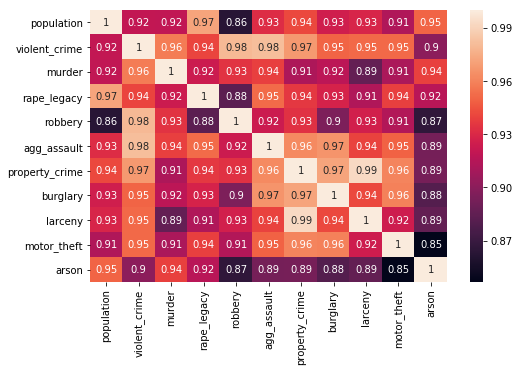

In [149]:
plt.figure(figsize=(8,5))
sns.heatmap(df3.corr(),annot=True)

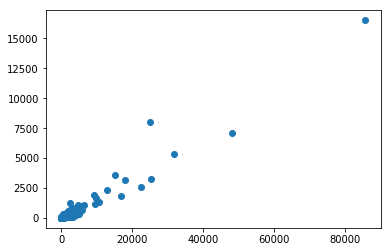

In [150]:
plt.scatter(df3.property_crime, df3.violent_crime)

In [151]:
features3['violent_crime'] = df3.violent_crime

In [152]:
Y = features3.property_crime.values.reshape(-1,1)
X = features3[['population','population_sq','murder','robbery','violent_crime']]
model = regr.fit(X, Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(X, Y).score(X, Y)))
print(cross_val_score(regr, X, Y, cv=10))

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

With 20% Holdout: 0.9066753311053807
Testing on Sample: 0.9704001955562817
[0.91781057 0.75841299 0.80546152 0.91416669 0.89638558 0.96426274
 0.545397   0.92626491 0.91453287 0.9133228 ]

Coefficients: 
 [[ 1.82238878e-02 -2.53427378e-09 -8.21075863e+01 -4.39908674e+01
   3.22776943e+00]]

Intercept: 
 [-39.06183533]

R-squared:
0.9704001955562817


By adding the new continuous feature of violent crime, there was a considerable increase in the r-squared value. Let's see if this addition carries over for New York's datasets.

In [154]:
features['violent_crime'] = df.violent_crime

Y = features.property_crime.values.reshape(-1,1)
X = features[['population','population_sq','murder','robbery','violent_crime']]
model = regr.fit(X, Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(X, Y).score(X, Y)))
print(cross_val_score(regr, X, Y, cv=10))

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

With 20% Holdout: -1220.051903495076
Testing on Sample: 0.9987036640607805
[ 9.33057808e-01  9.73507483e-01  6.87276899e-01  8.02301873e-01
  5.66707826e-01  3.35789385e-01 -1.29349503e+03  9.60369172e-01
  9.55509835e-01  1.55393746e-02]

Coefficients: 
 [[ 1.17461147e-02 -1.62871009e-09 -9.51638349e+00  9.92402288e+01
   3.01785680e+00]]

Intercept: 
 [-12.79432495]

R-squared:
0.9987036640607805


While adding any extra feature should increase the r-squared value, it is notable that the coefficient for the new feature 'violent_crime' (3.01785680e+00) shows that it is still a valuable addition for the multilinear regression model.

#### Assessing Model with Cross-Validation

In [188]:
# create training and testing vars
Y = features.property_crime
X = features[['population','population_sq','murder','robbery','violent_crime']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(278, 5) (278,)
(70, 5) (70,)


Text(0, 0.5, 'Predictions')

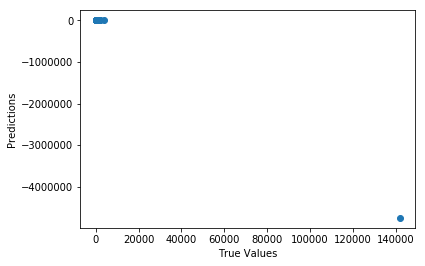

In [189]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [190]:
print ('Score:', model.score(X_test, y_test))

Score: -1208.3088593202772


In [191]:
# Perform 6-fold cross validation
scores = cross_val_score(model, X, Y, cv=6)
print ('Cross-validated scores:', scores)

Cross-validated scores: [ 9.73933075e-01  7.46245396e-01  7.07422364e-01 -2.48684391e+03
  9.58766905e-01  7.17233463e-01]


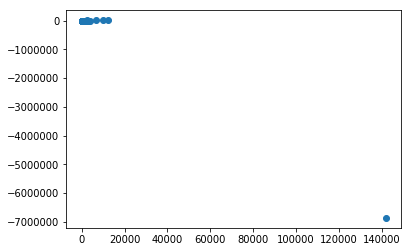

In [192]:
# Make cross validated predictions
from sklearn.model_selection import cross_val_predict

predictions = cross_val_predict(model, X, Y, cv=6)
plt.scatter(Y, predictions)

In [193]:
from sklearn import metrics

accuracy = metrics.r2_score(Y, predictions)
print ('Cross-Predicted Accuracy:', accuracy)

Cross-Predicted Accuracy: -2410.2644256977123
